#Setting the environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Sentiment analysis using LSTM # sets this as the current working directory.
!ls  # lists files in working directory

/content/drive/MyDrive/Sentiment analysis using LSTM
a1_IMDB_Dataset.csv   a3_IMDb_Unseen_Reviews.csv  lstm_model_acc_0.866.h5
a2_glove.6B.100d.txt  c1_lstm_model_acc_0.864.h5  lstm_model_acc_0.889.h5


#Loading the dataset

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import one_hot, Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv1D, GlobalMaxPooling1D, LSTM

In [ ]:
movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")
movie_reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
movie_reviews.isnull().any()

review       False
sentiment    False
dtype: bool

No missing values in the dataset.

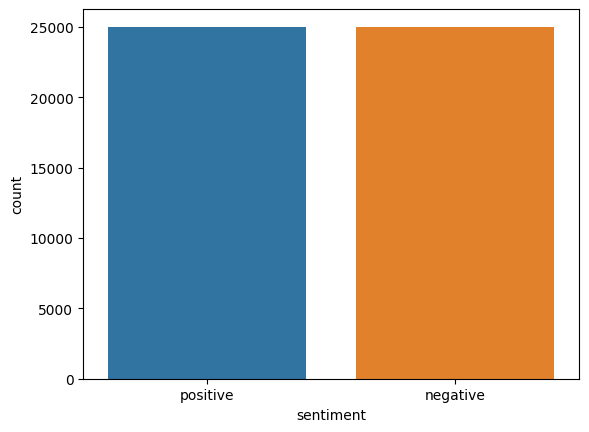

In [ ]:
sns.countplot(x='sentiment', data=movie_reviews)
plt.show()

The dataset is balanced.

# Preprocessing

In [ ]:
movie_reviews['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
# function to remove unwanted html tags such as <br><br/>.
regex = re.compile(r'<[^>]+>')

def remove_tags(text):
  return regex.sub('', text)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# function to preprocess the text
def preprocess_text(text):
  text = text.lower() # converts to lowercase

  text = remove_tags(text) # removes HTML tags

  text = re.sub('[^a-zA-Z]', ' ', text) # removes numbers and punctuations

  text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # removes single letters like 'i', 's' etc.

  text = re.sub(r'\s+', ' ', text) # removes multiple spaces

  # removes stopwords
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  text = pattern.sub('', text)

  return text

In [ ]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [ ]:
y = movie_reviews['sentiment']
y = np.array([1 if i == 'positive' else 0 for i in y]) # Bianry label encoding

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # splitting the dataset into test and train.

# Preparing embedding layer

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# adding 1 for additional dimension for words that are not present in the training data.
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

92394

In [ ]:
# padding all the reviews to a fixed length of 100.

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
embeddings_dictionary = dict() # this will store words and their corresponding embedding vector.
glove_file = open('a2_glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
  records = line.split()
  word = records[0]
  vector = np.asarray(records[1:], dtype='float32')
  embeddings_dictionary[word] = vector

glove_file.close()

In [ ]:
word_tokenizer.word_index['india']

2404

word_tokenizer.word_index is a dictionary which stores words with their corresponding tokens.

In [ ]:
embeddings_dictionary['india']

array([-0.95967  ,  0.30795  ,  0.90052  ,  1.0364   ,  0.0034906,
       -0.80758  , -1.139    ,  0.81109  , -0.67857  ,  0.52609  ,
       -0.072252 , -0.75613  ,  0.52847  ,  1.0927   , -0.51895  ,
       -0.21335  ,  0.18184  ,  0.40038  , -0.6547   ,  0.34626  ,
        0.92248  , -0.25001  ,  1.1779   ,  0.61006  ,  0.029763 ,
        0.4378   ,  0.53647  ,  0.68827  ,  0.14582  , -0.27446  ,
       -0.50289  ,  1.0366   , -0.29851  , -0.32927  ,  0.24944  ,
       -0.33779  ,  0.0083236, -0.21373  , -0.45898  , -0.23441  ,
       -1.2958   ,  0.74799  ,  0.78192  , -0.75644  ,  0.84375  ,
       -0.51725  ,  1.0952   ,  0.51768  ,  0.27906  , -0.033519 ,
       -0.1573   ,  0.7396   ,  0.39775  ,  1.132    , -0.69279  ,
       -2.0093   , -1.1731   , -0.14204  ,  1.5658   , -0.097956 ,
       -0.071165 , -0.18906  ,  0.037441 ,  0.48037  ,  0.29248  ,
        0.9216   ,  0.33285  ,  0.30963  ,  1.1272   ,  0.19965  ,
        0.47058  ,  0.019022 , -0.27432  , -0.49782  , -0.2944

For the word 'india' the corresponding index is 2404 and corresponding embedding vector is above. Thus, storing this vector to 2404th index in embedding_matrix.

In [ ]:
embedding_matrix = np.zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix[2404] # this is the embedding_vector for the word 'india'.

array([-0.95967001,  0.30794999,  0.90052003,  1.03639996,  0.0034906 ,
       -0.80757999, -1.13900006,  0.81108999, -0.67856997,  0.52609003,
       -0.072252  , -0.75612998,  0.52846998,  1.0927    , -0.51894999,
       -0.21335   ,  0.18184   ,  0.40037999, -0.65469998,  0.34626001,
        0.92247999, -0.25001001,  1.17789996,  0.61005998,  0.029763  ,
        0.43779999,  0.53647   ,  0.68826997,  0.14582001, -0.27445999,
       -0.50288999,  1.03659999, -0.29850999, -0.32927001,  0.24944   ,
       -0.33779001,  0.0083236 , -0.21373001, -0.45897999, -0.23441   ,
       -1.29579997,  0.74799001,  0.78192002, -0.75643998,  0.84375   ,
       -0.51725   ,  1.09519994,  0.51767999,  0.27906001, -0.033519  ,
       -0.1573    ,  0.7396    ,  0.39774999,  1.13199997, -0.69278997,
       -2.00929999, -1.17309999, -0.14204   ,  1.56579995, -0.097956  ,
       -0.071165  , -0.18906   ,  0.037441  ,  0.48036999,  0.29247999,
        0.92159998,  0.33285001,  0.30963001,  1.12720001,  0.19

#Model Training

##Simple Neural Network

In [ ]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False) # embedding layer works as a lookup table.

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# binary_crossentropy is used because there are only 2 classes.
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

snn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,249,401
Trainable params: 10,001
Non-trainable params: 9,239,400
_________________________________________________________________


In [ ]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 6ms/step - loss: 0.5608 - acc: 0.7111 - val_loss: 0.5030 - val_acc: 0.7656
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4510 - acc: 0.7964 - val_loss: 0.4963 - val_acc: 0.7642
Epoch 3/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4128 - acc: 0.8174 - val_loss: 0.4985 - val_acc: 0.7636
Epoch 4/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3904 - acc: 0.8292 - val_loss: 0.5188 - val_acc: 0.7560
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3760 - acc: 0.8353 - val_loss: 0.5182 - val_acc: 0.7591
Epoch 6/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3633 - acc: 0.8437 - val_loss: 0.5446 - val_acc: 0.7544


In [ ]:
score = snn_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.5680 - acc: 0.7450


In [ ]:
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.5679738521575928
Test Accuracy: 0.7450000047683716


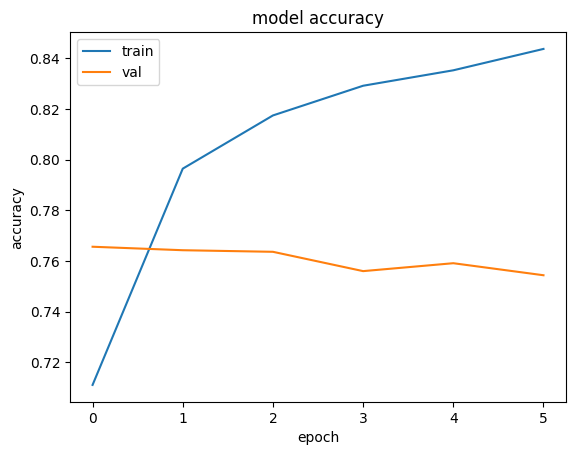

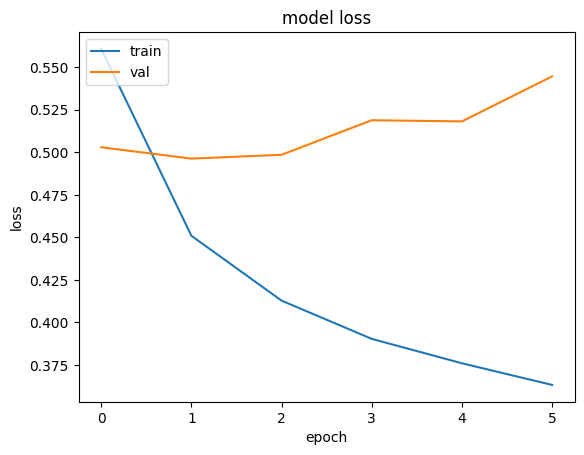

In [ ]:
plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Test accuracy and train accuracy have a certain difference.
Hence it could be said that model is overfitting on the training set.

##Convolutional Neural Networks

In [ ]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,303,657
Trainable params: 64,257
Non-trainable params: 9,239,400
_________________________________________________________________


In [ ]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 29s 111ms/step - loss: 0.4809 - acc: 0.7665 - val_loss: 0.3823 - val_acc: 0.8353
Epoch 2/6
250/250 [==============================] - 30s 121ms/step - loss: 0.3456 - acc: 0.8529 - val_loss: 0.3518 - val_acc: 0.8436
Epoch 3/6
250/250 [==============================] - 28s 110ms/step - loss: 0.2900 - acc: 0.8818 - val_loss: 0.3372 - val_acc: 0.8526
Epoch 4/6
250/250 [==============================] - 28s 112ms/step - loss: 0.2464 - acc: 0.9047 - val_loss: 0.3322 - val_acc: 0.8531
Epoch 5/6
250/250 [==============================] - 29s 115ms/step - loss: 0.2061 - acc: 0.9276 - val_loss: 0.3313 - val_acc: 0.8536
Epoch 6/6
250/250 [==============================] - 29s 116ms/step - loss: 0.1688 - acc: 0.9480 - val_loss: 0.3769 - val_acc: 0.8307


In [ ]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 5s 16ms/step - loss: 0.3819 - acc: 0.8375


In [ ]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.3819379508495331
Test accuracy: 0.8374999761581421


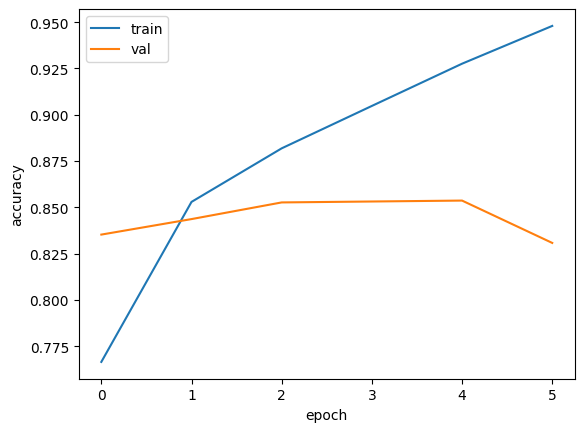

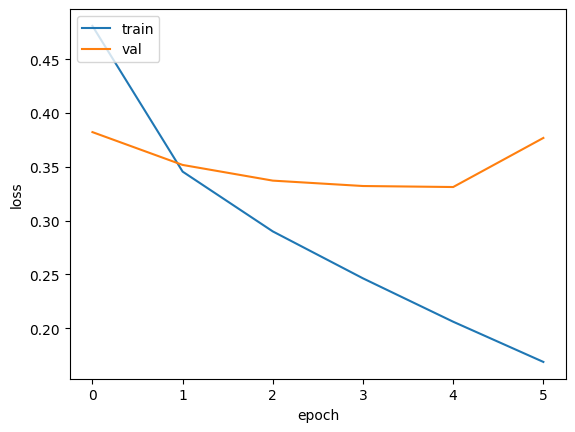

In [ ]:
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Test accuracy and train accuracy have a certain amount of difference. Test Accuracy is good but there is still difference between train accuracy and test accuracy, hence it could be said that model is overfitting on the training set.

##Recurrent Neural Network (LSTM)

RNNs are proven to work well with sequence data and since text is a sequence of words, a RNN can be used. LSTM is a variant of RNN,

In [ ]:
lstm_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________


In [ ]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 94s 365ms/step - loss: 0.4982 - acc: 0.7568 - val_loss: 0.4390 - val_acc: 0.8102
Epoch 2/6
250/250 [==============================] - 93s 371ms/step - loss: 0.4091 - acc: 0.8167 - val_loss: 0.3964 - val_acc: 0.8156
Epoch 3/6
250/250 [==============================] - 101s 403ms/step - loss: 0.3730 - acc: 0.8375 - val_loss: 0.3589 - val_acc: 0.8441
Epoch 4/6
250/250 [==============================] - 92s 370ms/step - loss: 0.3410 - acc: 0.8532 - val_loss: 0.3306 - val_acc: 0.8601
Epoch 5/6
250/250 [==============================] - 92s 367ms/step - loss: 0.3205 - acc: 0.8641 - val_loss: 0.3342 - val_acc: 0.8605
Epoch 6/6
250/250 [==============================] - 99s 397ms/step - loss: 0.3049 - acc: 0.8735 - val_loss: 0.3246 - val_acc: 0.8654


In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 22s 69ms/step - loss: 0.3287 - acc: 0.8608


In [ ]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.32871928811073303
Test accuracy: 0.86080002784729


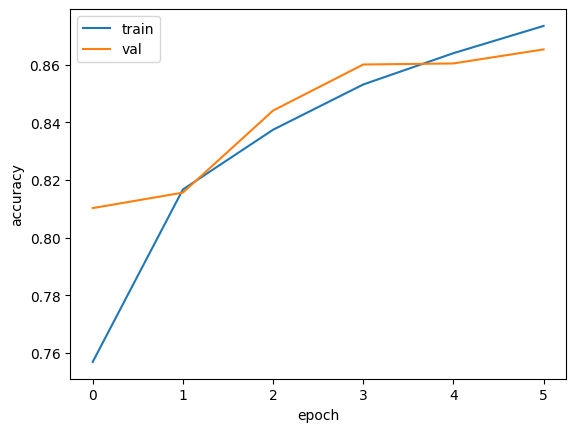

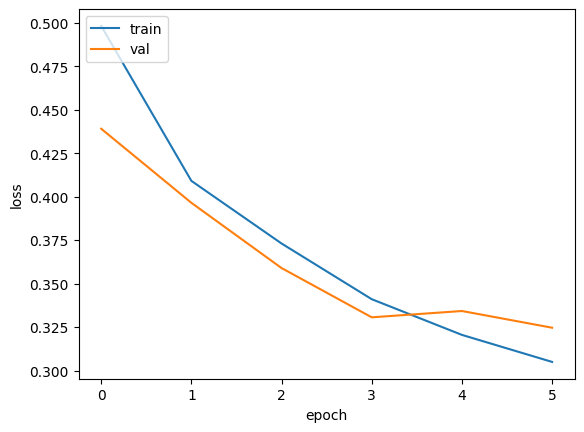

In [ ]:
plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Test accuracy is highest for LSTM and is similar to train accuracy hence no overfitting.

#Saving the best model

In [ ]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f'./lstm_model_acc_{round(score[1], 3)}.h5', save_format='h5')

#Making predictions on live IMDB data

In [ ]:
!ls

a1_IMDB_Dataset.csv	    c1_lstm_model_acc_0.864.h5	lstm_model_acc_0.889.h5
a2_glove.6B.100d.txt	    lstm_model_acc_0.861.h5
a3_IMDb_Unseen_Reviews.csv  lstm_model_acc_0.866.h5


In [ ]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='./lstm_model_acc_0.889.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()

In [ ]:
sample_reviews = pd.read_csv('a3_IMDb_Unseen_Reviews.csv')
sample_reviews

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [ ]:
unseen_reviews = sample_reviews['Review Text']

unseen_reviews_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_reviews_processed.append(review)

In [ ]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_reviews)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
predicted_sentiments = lstm_model.predict(unseen_padded)
predicted_sentiments

1/1 [==============================] - 1s 843ms/step


array([[0.8851224 ],
       [0.99022865],
       [0.19650973],
       [0.40029782],
       [0.94745713],
       [0.03470576]], dtype=float32)

In [ ]:
sample_reviews['predicted_reviews'] = np.round(predicted_sentiments*10, 1)

sample_reviews

,Unnamed: 0,Movie,Review Text,IMDb Rating,predicted_reviews
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,2.0
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,4.0
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.5
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.3


The model also achieves high accuracy when predicting the reviews.

#Playing around with the model

In [ ]:
def predict(review):
  review = preprocess_text(review)
  tokenized_review = word_tokenizer.texts_to_sequences(review)
  padded_review = pad_sequences(tokenized_review, padding='post', maxlen=100)
  predicted_sentiment = lstm_model.predict(padded_review.reshape(1, -1), verbose=0)

  if predicted_sentiment[0][0] > 0.5:
    sentiment_label = "Positive"
  else:
    sentiment_label = "Negative"

  print('Predicted Sentiment:', sentiment_label)
  print('Predicted Review:', np.round(predicted_sentiment[0][0]*10, 1))

In [ ]:
predict('not satisfied by this movie')

Predicted Sentiment: Negative
Predicted Review: 0.3


In [ ]:
predict('excellent movie must watch')

Predicted Sentiment: Positive
Predicted Review: 9.9
